In [4]:
%load_ext autoreload
%autoreload 2
import os
if os.path.basename(os.path.abspath(os.curdir)) == 'notebook':
    os.chdir('../.')

import os 
import sys
import pickle
from sketch_gnn.utils import flat_array
from sketch_gnn.dataloader.generate_dataModule import SketchGraphDataModule
from sketch_gnn.models.gat import GaT
from sketch_gnn.models.predict import PredictSketch
from sketch_gnn.utils.to_dict import parse_config, yaml_to_dict
from sketch_gnn.utils.logger import logger
import torch

SAVED_MODEL_PATH= 'Sandbox/gat_logs/version_15/checkpoints/gat-epoch=84-val_loss=0.00.ckpt'
HPARAMS_PATH = 'Sandbox/gat_logs/version_15/hparams.yaml'
SEQUENCE_DATA= 'data/normalization_output_merged.npy'

# Load config
conf = parse_config('config/gat.yml')
d_train = conf.get('train')
d_val_data = conf.get('val_data')
d_train['batch_size'] = 1
d_val_data['prop_max_edges_given'] = 0.8
with open(conf.get('prep_parms_path'), 'rb') as f:
    d_prep = pickle.load(f)

d_model = yaml_to_dict(HPARAMS_PATH)
model = GaT(d_model, d_prep)

conf['edge_idx_map'] = d_prep.get('edge_idx_map')
conf['node_idx_map'] = d_prep.get('node_idx_map')

sketchPredictionmodel = PredictSketch.load_from_checkpoint(
    checkpoint_path=SAVED_MODEL_PATH,
    model= model,
    conf= None) # No need for training config
logger.info('-- Model initialization: end')

# Load dataloder 
graph_datamodule = SketchGraphDataModule(conf)
dataloader = graph_datamodule.val_dataloader()
batch_iterator = iter(dataloader)

# Load sequence dataset for visualization
sequence_data = flat_array.load_flat_array(SEQUENCE_DATA)

EDGE_IDX_MAP = d_prep.get('edge_idx_map')
NODE_IDX_MAP = d_prep.get('node_idx_map')




DEBUG:sketch_gnn.models.numerical_features.generator:{'POINT': {'status_construction': 2, 'x': 50, 'y': 50}, 'LINE': {'status_construction': 2}, 'CIRCLE': {'status_construction': 2, 'radius': 50}, 'ARC': {'status_construction': 2, 'radius': 50, 'angle_start': 50, 'angle_end': 50}}
INFO:sketch_gnn.utils.logger:-- Model initialization: end
INFO:sketch_gnn.dataloader.generate_dataModule:-- Load Validation Set


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluate output

In [5]:
from sketch_gnn.inference.eval import EvalPrediction

batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.95)
pred.print_prediction()

----------INFERRED----------


----------MISSED----------
Label: COINCIDENT                    inferred: COINCIDENT                                    score= 0.95      
Label: TANGENT                       inferred: TANGENT                                       score= 0.08      
Label: COINCIDENT                    inferred: HORIZONTAL                                    score= 0.02      INCORRECT


## Visualize sketches
requires Sam

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

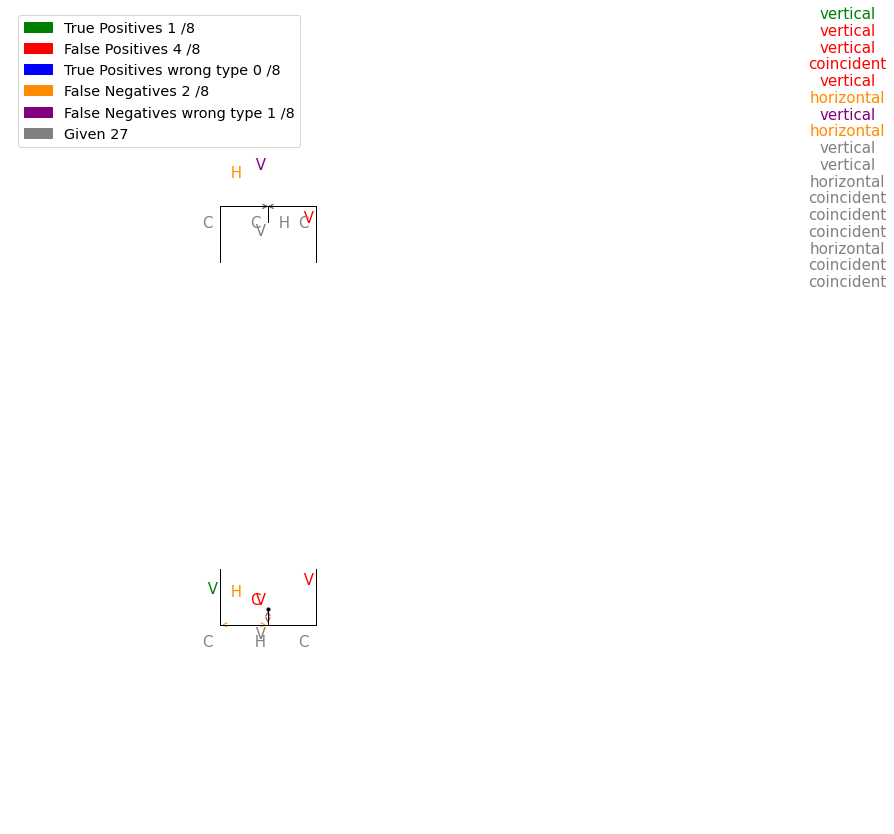

In [10]:
from sam.sketch import Sketch
from sketch_gnn.inference.visualization import display_constraint, display_inference, display_specific_constraint, filter_edges_for_visu

batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.90)
seq_idx = batch['sequence_idx'][0]
sketch = Sketch()
sketch.sequence = sequence_data[seq_idx]
display_specific_constraint(sketch, pred, request=-1)

## Interactive plots

requires ipywidgets

In [11]:
from ipywidgets import interact, widgets
import warnings
from sam.constraint import Constraint
from sketch_gnn.inference.interactive import interactive_inference, interactive_sketch

In [12]:
batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.95)
seq_idx = batch['sequence_idx'][0]
sketch = Sketch()
sketch.sequence = sequence_data[seq_idx]
interactive_inference(sketch, pred)

interactive(children=(IntSlider(value=-1, description='n', max=15, min=-1), Output()), _dom_classes=('widget-i…

In [13]:
batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.95)
seq_idx = batch['sequence_idx'][0]
sketch = Sketch()
sketch.sequence = sequence_data[seq_idx]
interactive_sketch(sketch)

interactive(children=(IntSlider(value=-1, description='n', max=13, min=-1), Output()), _dom_classes=('widget-i…